A.	PyTorch GPU Acceleration

In [3]:
import torch
import timeit
x = torch.rand(2**11, 2**11)
time_cpu = timeit.timeit("x@x", globals=globals(), number=100)
print(time_cpu)


15.192109539


In [4]:
print("Is CUDA available? :", torch.cuda.is_available())
device = torch.device("cuda")

Is CUDA available? : True


In [5]:
x = x.to(device)
time_gpu = timeit.timeit("x@x", globals=globals(), number=100)
print(time_gpu)

0.11362035599995579


In [14]:
x = torch.rand(128, 128).to(device)
y = torch.rand(128, 128)
x*y

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [15]:
def moveTo(obj, device):
  '''
  obj: the python object to move to a device, or to move its contents to a device
  device: the compute device to move objects to
  '''
  if isinstance(obj, list):
    return [moveTo(x, device) for x in obj]
  elif isinstance(obj, tuple):
    return tuple(moveTo(list(obj), device))
  elif isinstance(obj, set):
    return set(moveTo(list(obj), device))
  elif isinstance(obj, dict):
    to_ret = dict()
    for key, value in obj.items():
      to_ret[moveTo(key, device)] = moveTo(value, device)
    return to_ret
  elif hasattr(obj, "to"):
    return obj.to(device)
  else:
    return obj

some_tensors = [torch.tensor(1), torch.tensor(2)]
print(some_tensors)
print(moveTo(some_tensors, device))


[tensor(1), tensor(2)]
[tensor(1, device='cuda:0'), tensor(2, device='cuda:0')]


B.	PyTorch Automatic Differentiation

<Axes: >

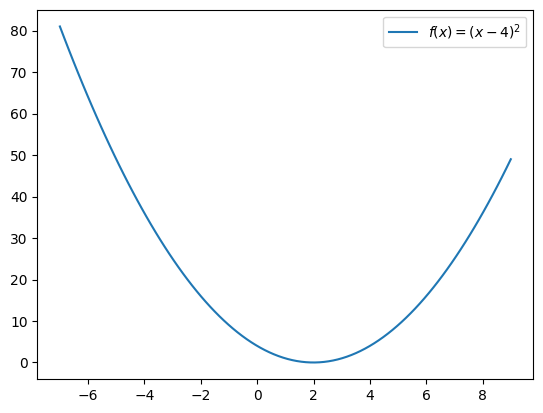

In [21]:
import numpy as np
import seaborn as sns

def f(x):
  return torch.pow((x-2.0), 2)

x_axis_vals = np.linspace(-7,9,100)
y_axis_vals = f(torch.tensor(x_axis_vals)).numpy()
sns.lineplot(x=x_axis_vals, y=y_axis_vals, label='$f(x)=(x-2)^2$')


<Axes: >

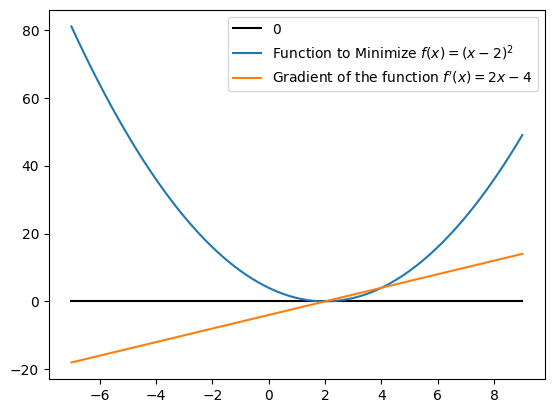

In [22]:
def fP(x): #Defines the derivative of f(x) manually
  return 2*x-4
y_axis_vals_p = fP(torch.tensor(x_axis_vals)).numpy()

#Draws a black line at 0 so we can easily tell if something is positive or
#negative
sns.lineplot(x=x_axis_vals, y=[0.0]*len(x_axis_vals), label="0", \
             color='black')
sns.lineplot(x=x_axis_vals, y=y_axis_vals, \
             label='Function to Minimize $f(x) = (x-2)^2$')
sns.lineplot(x=x_axis_vals, y=y_axis_vals_p, \
             label="Gradient of the function $f'(x)=2 x - 4$")


In [23]:
import torch
x = torch.tensor([-3.5], requires_grad=True)
print(x.grad)


None


In [24]:
value = f(x)
print(value)

tensor([30.2500], grad_fn=<PowBackward0>)


In [25]:
value.backward()
print(x.grad)


tensor([-11.])


In [26]:
x = torch.tensor([-3.5], requires_grad=True)
x_cur = x.clone()
x_prev = x_cur*100

#threshold for the current and previous to be close enough
#before stop.
epsilon = 1e-5
eta = 0.1 #learning rate

while torch.linalg.norm(x_cur-x_prev) > epsilon:
  x_prev = x_cur.clone() #so that x_prev, x_cur don't point to same object.
  value = f(x) #next few lines compute function, gradient, and update.

  value.backward()
  x.data -= eta * x.grad
  x.grad.zero_() #Zeros out the old gradient,

  x_cur = x.data #Accesses .data to avoid autograd mechanics.
print(x_cur)

tensor([2.0000])


C.	PyTorch Optimizing Parameters

In [28]:
x_param = torch.nn.Parameter(torch.tensor([-3.5]), requires_grad=True)

In [29]:
optimizer = torch.optim.SGD([x_param], lr=eta)

In [30]:
x = torch.tensor([-3.5], requires_grad=True)
optimizer = torch.optim.SGD([x_param], lr=eta)

for epoch in range(60):
  optimizer.zero_grad()
  loss_incurred = f(x_param)
  loss_incurred.backward()
  optimizer.step() #x.data -= eta * x.grad

print(x_param.data)


tensor([2.0000])
